# Obsah

> ## Úvod

> ## Knižnice

> ## Dataset

> ## Chýbajúce hodnoty

>> ### Zjednotenie formátov dát

>> ### Odvodenie chýbajúcich hodnôt po riadkoch

>> ### Doplnenie chýbajúcich hodnôt po stĺpcoch

> ## Vychýlené hodnoty

> ## Normalizácia údajov

> ## Transformácia numerických atribútov na kategorické

> ## Transformacia kategorických údajov na numerické

> ## Vytváranie atribútov kombinovanim

> ## Zdroje

## Doležité parametre
DecisionTreeClassifier(
criterion

max_depth=None

min_samples_leaf - počet pozorovani vo vyslednej podmnozine

class_weight=None

# Úvod
Na základe identifikovaných problémov v dátach a návrhu ich riešenia v predchádzajúcej fáze treba zrealizovať predspracovanie. Výsledkom by mala byť upravená dátová sada (vo formáte ​csv​) vo vhodnom tvare pre zvolený algoritmus strojového učenia (v našom prípade rozhodovacie stromy​). Zároveň, keďže predspracovaním sa mohol zmeniť tvar a charakteristiky dát (počet atribútov, distribúcie hodnôt a pod.), treba znovu zrealizovať podstatné časti prieskumnej analýzy, pričom v tejto fáze je potrebné zamerať sa aj na vzťahy medzi jednotlivými atribútmi.

# Knižnice

In [183]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn import preprocessing

#regular expression
import re

#Nastavenie rozmerov zobrazovaných grafov
plt.rcParams['figure.figsize'] = 9, 6
from IPython.display import Image

# Dataset

In [117]:
file_path = "data/zadanie4/train.csv"
# Načítame si súbor s datasetom so separátom ',' a ako index nastavime prvý stĺpec
train_data = pd.read_csv(file_path, sep=',', index_col=0)
# Pomenujeme si index
train_data.index.name = 'id'
#train_data.info()

In [116]:
file_path = "data/zadanie4/test.csv"
# Načítame si súbor s datasetom so separátom ',' a ako index nastavime prvý stĺpec
test_data = pd.read_csv(file_path, sep=',', index_col=0)
# Pomenujeme si index
test_data.index.name = 'id'
#test_data.info()

In [193]:
#Aby sme mohli pracovat 
#data = train_data
data = test_data

In [230]:
#Zjednotenie názvov stĺpcov
data = data.rename(columns=lambda x: re.sub('[ -]','_', x.strip()))

# Chýbajúce hodnoty

### Zjednotenie formátov dát

In [239]:
#help(data.select_dtypes)
#Selektneme si vsetky atribúty, ktoré majú nejasný dátový
for col_name in data.select_dtypes('object'):
    #Spočítame si pre každý "kategorický" atribút počet jeho jedinečných hodnôt
    uniq_values_count = len(data[col_name].unique())
    # vypíšeme si počty
    print(col_name,":",uniq_values_count) 

sex : 3
FTI : 210
TBG : 1
referral_source : 5
education : 16
relationship : 9
date_of_birth : 2457
personal_info : 700
class : 4


Pre atribúty s veľkým počtom kategorických atribútov sa ich pokúsime zredukovať. Pre všetky vyššie atribúty nastavíme správny formát dát a prekonvertujeme na číselnú reprezentáciu.

**KOREKCIA:** FTI prekonvertujeme na dátový typ float

In [163]:
#help(data.to_numeric)
#If ‘coerce’, then invalid parsing will be set as NaN
data['FTI'] = pd.to_numeric(data['FTI'], errors='coerce')

In [164]:
new_column = 'education_num'
#data['education-num']
data[new_column] = pd.to_numeric(data['education-num'], errors='coerce')
data[new_column] = data['education-num'].apply(lambda x: abs(x)/100 if abs(x) > 100 else x)
data[new_column].value_counts()

9.0     894
10.0    670
13.0    437
14.0    138
11.0    130
12.0    103
7.0      97
6.0      79
8.0      54
4.0      45
15.0     42
5.0      41
16.0     25
3.0      24
2.0      17
1.0       4
Name: education_num, dtype: int64

In [211]:
data['sex'].value_counts()

F    650
M    282
?     40
Name: sex, dtype: int64

In [223]:
#pd.get_dummies(data['sex'], dummy_na=False)
data['sex'].isnull().sum()

110

In [221]:
data['sex'].replace(['F', 'M', '?'], ['Female', 'Male', np.NAN], inplace=True)

Zmena hodnôt **M -> Male** a **F -> Female**, **? -> NaN**. 


PJ NEROZUMIEM: Túto úpravu robíme kvôli tomu, aby sme pri upravovaní hodnôt F, f, T, t ... mohli upraviť tieto hodnoty globálne.

In [222]:
data['sex'].value_counts()

Female    1830
Male       860
Name: sex, dtype: int64

Zmena hodnôt **f, F, FALSE -> False** a **t, T, TRUE -> True**

In [235]:
data.replace(['f', 'F', 'FALSE', 't', 'T', 'TRUE'], [False, False, False, True, True, True], inplace=True)
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2800 entries, 0 to 2799
Data columns (total 39 columns):
age                          2799 non-null float64
sex                          2690 non-null object
on_thyroxine                 2800 non-null bool
query_on_thyroxine           2800 non-null bool
on_antithyroid_medication    2800 non-null bool
sick                         2800 non-null bool
pregnant                     2800 non-null bool
thyroid_surgery              2800 non-null bool
I131_treatment               2800 non-null bool
query_hypothyroid            2800 non-null bool
query_hyperthyroid           2800 non-null bool
lithium                      2800 non-null bool
goitre                       2800 non-null bool
tumor                        2800 non-null bool
hypopituitary                2800 non-null bool
psych                        2800 non-null bool
TSH_measured                 2800 non-null bool
TSH                          2516 non-null float64
T3_measured          

Ujednotenie názvov v stĺpci **relationship**. 
Own-child -> Own_child
Not-in-family -> Not_in_family
Other-relative -> Other_relative

In [10]:
data['relationship'].value_counts()

 Not-in-family     809
 Husband           550
 Unmarried         510
 Own-child         441
 Wife              253
 Not_in_family      95
 Other-relative     80
 Own_child          53
 Other_relative      9
Name: relationship, dtype: int64

In [11]:
data['relationship'] = data['relationship'].apply(str.strip)

'''data['relationship'] = data['relationship'].map({
    'Own-child': 'Own_child', 
    'Not-in-family': 'Not_in_family', 
    'Other-relative': 'Other_relative',
    'Unmarried': 'Unmarried',
    'Wife': 'Wife',
    'Husband': 'Husband'
})'''

data['relationship'].replace(['Own-child', 'Not-in-family', 'Other-relative'], ['Own_child', 'Not_in_family', 'Other_relative'], inplace=True)

In [12]:
data['relationship'].value_counts()

Not_in_family     904
Husband           550
Unmarried         510
Own_child         494
Wife              253
Other_relative     89
Name: relationship, dtype: int64

Ujednotenie formátu atribútu **date_of_birth**

In [13]:
data['date_of_birth'].head(30)

id
0              1946-02-03
1              1965-08-27
2              1955-04-15
3              1994-03-26
4              1955-01-21
5              1961-12-10
6              1934-03-03
7              1949-07-21
8              1999-01-06
9              1945-11-10
10             1999-09-20
11                    NaN
12                    NaN
13             1970-09-28
14             1942-08-15
15             07/07/1973
16             1979-12-04
17             18/01/1940
18             15/10/1952
19             1981-07-19
20             1940-05-20
21             1957-04-28
22             1998-03-25
23             1935-11-23
24             1948-08-21
25             24/01/1942
26             1987-07-21
27    1983-09-21 00 00 00
28    1953-06-10 00:00:00
29             1935-08-10
Name: date_of_birth, dtype: object

In [14]:
data['date_of_birth'] = pd.to_datetime(data['date_of_birth'], errors='coerce')

In [15]:
data['date_of_birth'].head(30)

id
0    1946-02-03
1    1965-08-27
2    1955-04-15
3    1994-03-26
4    1955-01-21
5    1961-12-10
6    1934-03-03
7    1949-07-21
8    1999-01-06
9    1945-11-10
10   1999-09-20
11          NaT
12          NaT
13   1970-09-28
14   1942-08-15
15   1973-07-07
16   1979-12-04
17   1940-01-18
18   1952-10-15
19   1981-07-19
20   1940-05-20
21   1957-04-28
22   1998-03-25
23   1935-11-23
24   1948-08-21
25   1942-01-24
26   1987-07-21
27          NaT
28   1953-06-10
29   1935-08-10
Name: date_of_birth, dtype: datetime64[ns]

Vidíme, že riadky, kde bolo **00 00 00** nám zmenilo na NaT. To znamená že v tomto riadku sa nachádza hodnota, ktorá sa nedala sparsovať. 

Rozdelenie stĺpca **personal_info** do viacerých stĺpcov

In [241]:
df_personal_data = pd.DataFrame(data['personal_info'].str.replace('\n','|').str.replace('--','|').str.split('|', expand=False).tolist(), columns=['job','state', 'parents_definition', 'segment', 'race'])

Atribút je teraz rozdelený do viacerých stĺpcov **job, state, parents_definition, segment, race**, ale je potrebné v nich urobiť nejaké úpravy. 

In [166]:
df_personal_data.head()

,job,state,parents_definition,segment,race
0,Other-service,United-States,Widowed,private,Black
1,Adm-clerical,United-States,Separated,Local-gov,White
2,Sales,United-States,Married-civ-spouse,private,White
3,Sales,United-States,Never-married,Private,Black
4,Adm-clerical,United-States,Never-married,Private,White


In [167]:
df_personal_data['job'].value_counts()

Adm-clerical         430
Other-service        400
Prof-specialty       382
Exec-managerial      355
Sales                316
Craft-repair         202
?                    201
Machine-op-inspct    160
Tech-support          84
Transport-moving      74
Handlers-cleaners     60
Farming-fishing       56
Protective-serv       51
Priv-house-serv       29
Name: job, dtype: int64

In [168]:
for col in df_personal_data.columns:
    df_personal_data[col] = df_personal_data[col].str.replace('-','_')

df_personal_data.head()

,job,state,parents_definition,segment,race
0,Other_service,United_States,Widowed,private,Black
1,Adm_clerical,United_States,Separated,Local_gov,White
2,Sales,United_States,Married_civ_spouse,private,White
3,Sales,United_States,Never_married,Private,Black
4,Adm_clerical,United_States,Never_married,Private,White


Teraz môžeme vytvorené stĺpce z atribútu **personal_info** pripojiť k celému datasetu a vymazať atribút **personal_info**.

In [169]:
data = data.drop(['personal_info'], axis=1) # vymazanie atribútu personal_info
data = data.join(df_personal_data)          # pridanie nových atribútov do nášho datasetu

In [170]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2800 entries, 0 to 2799
Data columns (total 43 columns):
age                          2799 non-null float64
sex                          2800 non-null object
on thyroxine                 2800 non-null object
query on thyroxine           2800 non-null object
on antithyroid medication    2800 non-null object
sick                         2800 non-null object
pregnant                     2800 non-null object
thyroid surgery              2800 non-null object
I131 treatment               2800 non-null object
query hypothyroid            2800 non-null object
query hyperthyroid           2800 non-null object
lithium                      2800 non-null object
goitre                       2800 non-null object
tumor                        2800 non-null object
hypopituitary                2800 non-null object
psych                        2800 non-null object
TSH measured                 2800 non-null object
TSH                          2516 non-null

Rozdelenie atribútu **class** do dvoch nových atribútov.

In [125]:
data['class'].head()

id
0    negative.|1231
1     negative.|329
2    negative.|2518
3     negative.|821
4     negative.|951
Name: class, dtype: object

In [237]:
#data = train_data
column1_name = 'class'
#Nepotrebujeme
column2_name = 'second_id'
df_class = pd.DataFrame(data["class"].str.split('\.\|').tolist(), columns = [column1_name,column2_name])
df_class['class'].value_counts()

negative               2713
underreplacement         35
replacement therapy      29
overreplacement          23
Name: class, dtype: int64

In [238]:
# vymazanie atribútu class
data = data.drop(['class'], axis=1) 
# pridanie nových atribútov do nášho datasetu
data = data.join(df_class[column1_name])

In [162]:
data['class'].value_counts()

negative               2713
underreplacement         35
replacement therapy      29
overreplacement          23
Name: class, dtype: int64

In [154]:

#data.info()
data1.

AttributeError: 'DataFrame' object has no attribute 'values_count'

### Odvodenie chýbajúcich hodnôt po riadkoch

### Doplnenie chýbajúcich hodnôt po stĺpcoch

# Vychýlené hodnoty TODO:

# Pomocné grafové examples

- data.fillna((0: 1, 1:1, 2:1))
- data.isnull().sum()
- data.dropna(how='all')
- data.plot.box()

In [28]:
ts = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))

ts = ts.cumsum()
    
df = pd.DataFrame(np.random.randn(1000, 4), index=ts.index, columns=list('ABCD'))

df = df.cumsum()
df3 = pd.DataFrame(np.random.randn(1000, 2), columns=['B', 'C']).cumsum()

df3['A'] = pd.Series(list(range(len(df))))
df3.head()

,B,C,A
0,-2.406376,1.016693,0
1,-2.226895,0.094967,1
2,-2.871334,0.579773,2
3,-2.793452,1.144669,3
4,-1.654493,0.144395,4


In [29]:
df.head(2)#.plot.hist(); plt.axhline(0, color='g')


,A,B,C,D
2000-01-01,-0.182323,0.522500,2.000581,0.591864
2000-01-02,1.184225,0.536334,1.259496,1.016512


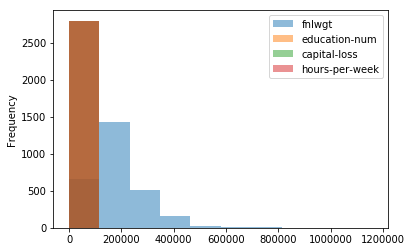

In [30]:
data.select_dtypes('int').plot.hist(alpha=0.5)

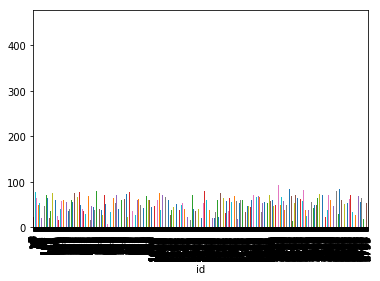

In [31]:
df2 = pd.DataFrame(np.random.rand(10, 4), columns=['a', 'b', 'c', 'd'])

#df2.plot.bar(stacked=True);
plt.figure()
data['age'].plot.bar()


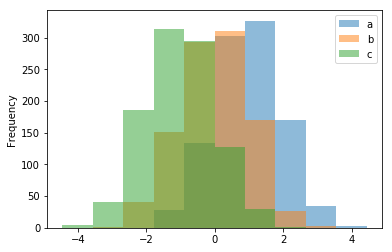

In [32]:
df4 = pd.DataFrame({'a': np.random.randn(1000) + 1, 'b': np.random.randn(1000),'c': np.random.randn(1000) - 1}, columns=['a', 'b', 'c'])
plt.figure();

df4.plot.hist(alpha=0.5)

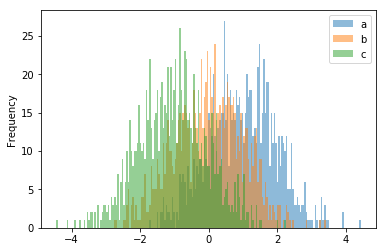

In [33]:
df4.plot.hist(alpha=0.5, bins=200)

In [34]:
plt.figure()
df['A'].head()

2000-01-01   -0.182323
2000-01-02    1.184225
2000-01-03    0.383364
2000-01-04    2.642323
2000-01-05    3.344534
Freq: D, Name: A, dtype: float64

In [35]:
df['A'].diff().head()

2000-01-01         NaN
2000-01-02    1.366549
2000-01-03   -0.800861
2000-01-04    2.258959
2000-01-05    0.702211
Freq: D, Name: A, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1a8b9cc0>,
      dtype=object)

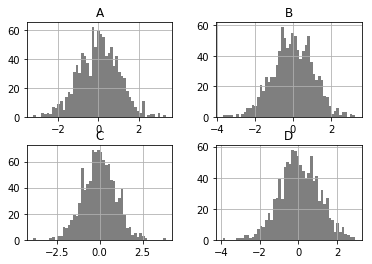

In [36]:
df.diff().hist(color='k', alpha=0.5, bins=50)

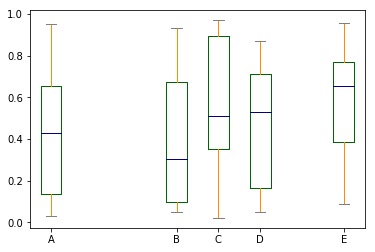

In [37]:
df = pd.DataFrame(np.random.rand(10, 5), columns=['A', 'B', 'C', 'D', 'E'])
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
df.plot.box(color=color, sym='r+', positions=[1, 4, 5, 6, 8])

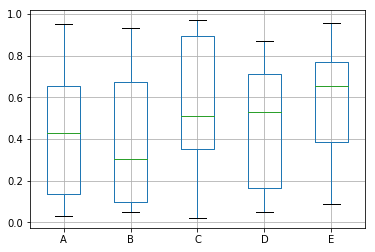

In [38]:
df.boxplot()

In [39]:
df = pd.DataFrame(np.random.rand(10,2), columns=['Col1', 'Col2'] )

df['X'] = pd.Series(['A','A','A','A','A','B','B','B','B','B'])

plt.figure();
df
#bp = df.boxplot(by='X')

,Col1,Col2,X
0,0.205421,0.681066,A
1,0.788275,0.453952,A
2,0.716099,0.226500,A
3,0.803124,0.529056,A
4,0.529804,0.219647,A
5,0.349914,0.152936,B
6,0.844744,0.346391,B
7,0.721801,0.683488,B
8,0.943237,0.763800,B
9,0.856835,0.768115,B


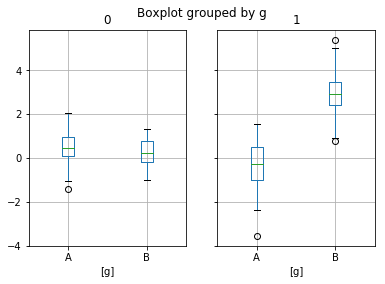

In [40]:
np.random.seed(1234)
df_box = pd.DataFrame(np.random.randn(50, 2))
df_box['g'] = np.random.choice(['A', 'B'], size=50)
df_box.loc[df_box['g'] == 'B', 1] += 3
bp = df_box.boxplot(by='g')

In [41]:
df = pd.DataFrame(np.random.rand(50, 4), columns=['a', 'b', 'c', 'd'])

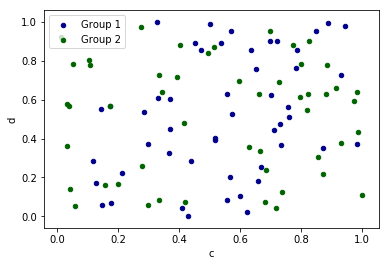

In [42]:
ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Group 1');

df.plot.scatter(x='c', y='d', color='DarkGreen', label='Group 2', ax=ax);

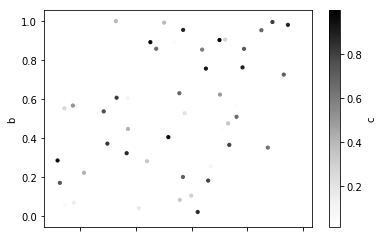

In [43]:
df.plot.scatter(x='a', y='b', c='c', s=10);

# Zdroje
Príklady ako pracovať s pandas - https://pandas.pydata.org/pandas-docs/stable/cookbook.html#cookbook-plotting

Robenie grafov v pandas - https://pandas.pydata.org/pandas-docs/stable/visualization.html